In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the both Datasets
fear = pd.read_csv('/content/fear_greed_index.csv')
trades = pd.read_csv('/content/historical_data.csv')

print("Fear/Greed shape:", fear.shape)
print("Trader data shape:", trades.shape)

# display(fear.head())
display(trades.head())

Fear/Greed shape: (2644, 4)
Trader data shape: (74503, 16)


/tmp/ipython-input-334982207.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  trades = pd.read_csv('/content/historical_data.csv')


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


In [3]:
# Check Missing and null values
print("Fear missing:\n", fear.isna().sum())
print("Fear duplicates:", fear.duplicated().sum())

print("Trades missing:\n", trades.isna().sum())
print("Trades duplicates:", trades.duplicated().sum())

Fear missing:
 timestamp         0
value             0
classification    0
date              0
dtype: int64
Fear duplicates: 0
Trades missing:
 Account             0
Coin                0
Execution Price     0
Size Tokens         1
Size USD            1
Side                1
Timestamp IST       1
Start Position      1
Direction           1
Closed PnL          1
Transaction Hash    1
Order ID            1
Crossed             1
Fee                 1
Trade ID            1
Timestamp           1
dtype: int64
Trades duplicates: 0


In [4]:
# Convert Date columns
fear["date"] = pd.to_datetime(fear["date"]).dt.date
fear["sentiment"] = fear["classification"]
fear = fear[["date","sentiment"]]

In [29]:
# Converts the "Timestamp" column into a proper datetime format.
trades["Timestamp"] = pd.to_datetime(trades["Timestamp"])
trades["date"] = trades["Timestamp"].dt.date

In [30]:
# Type of date value is stored
print(type(trades["date"].iloc[0]))
print(type(fear["date"].iloc[0]))

<class 'datetime.date'>
<class 'datetime.date'>


In [31]:
# Remove Duplicates
fear = fear.drop_duplicates(subset=["date"])

In [9]:
# Create a daily summary from the 'trades' DataFrame
# For example, count the number of trades per day
daily = trades.groupby('date').size().reset_index(name='trade_count')

merged = daily.merge(fear, on="date", how="left")
merged = merged.dropna(subset=["sentiment"])

In [10]:
# Win or loss
trades["is_win"] = trades["Closed PnL"] > 0

# Long / Short
trades["Side"] = trades["Side"].str.upper()
trades["is_long"] = trades["Side"].isin(["BUY", "LONG"])
trades["is_short"] = trades["Side"].isin(["SELL", "SHORT"])

# Daily aggregation
daily = trades.groupby(["Account","date"]).agg(
    daily_pnl=("Closed PnL","sum"),
    num_trades=("Closed PnL","count"),
    win_rate=("is_win","mean"),
    avg_size_usd=("Size USD","mean"),
    longs=("is_long","sum"),
    shorts=("is_short","sum")
).reset_index()

# Long/Short ratio
daily["long_short_ratio"] = daily["longs"] / (daily["shorts"] + 1)

daily.head()


,Account,date,daily_pnl,num_trades,win_rate,avg_size_usd,longs,shorts,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,1.600230e+06,3818,0.359612,16159.576734,1711,2107,0.811670
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,4.788532e+04,7280,0.442720,1653.226327,3055,4225,0.722906
2,0x420ab45e0bd8863569a5efbb9c05d91f40624641,1970-01-01,1.995056e+05,383,0.234987,5189.367128,101,282,0.356890
3,0x430f09841d65beb3f27765503d0f850b8bce7713,1970-01-01,4.165419e+05,1237,0.484236,2397.824753,302,935,0.322650
4,0x4f93fead39b70a1824f981a54d4e55b278e9f760,1970-01-01,3.089759e+05,7584,0.360364,17098.171055,4172,3412,1.222385


In [14]:
fear["date"] = pd.to_datetime(fear["date"]).dt.date
fear = fear.drop_duplicates(subset=["date"])
print("Fear range:", fear["date"].min(), "to", fear["date"].max())


Fear range: 2018-02-01 to 2025-05-02


In [15]:
# Convert to only Fear / Greed
fear["sentiment"] = fear["sentiment"].replace({
    "Extreme Fear": "Fear",
    "Extreme Greed": "Greed"
})

# Keep only Fear and Greed
fear = fear[fear["sentiment"].isin(["Fear","Greed"])]

print(fear["sentiment"].value_counts())


sentiment
Fear     1289
Greed     959
Name: count, dtype: int64


In [19]:
trades["Timestamp IST"] = pd.to_datetime(trades["Timestamp IST"], format="%d-%m-%Y %H:%M", errors="coerce")
trades["date"] = trades["Timestamp IST"].dt.date

# Get min and max from the datetime64[ns] Series directly to avoid type comparison issues.
# This handles NaT values correctly by default.
min_date_val = trades["Timestamp IST"].min()
max_date_val = trades["Timestamp IST"].max()

# Check if valid dates were found before printing
if pd.isna(min_date_val) or pd.isna(max_date_val):
    print("No valid date range found in trades data.")
else:
    print("Trades date range:", min_date_val.date(), "to", max_date_val.date())

Trades date range: 2023-12-05 to 2025-05-01


In [20]:
trades["is_win"] = trades["Closed PnL"] > 0

trades["Side"] = trades["Side"].str.upper()
trades["is_long"] = trades["Side"].isin(["BUY","LONG"])
trades["is_short"] = trades["Side"].isin(["SELL","SHORT"])

daily = trades.groupby(["Account","date"]).agg(
    daily_pnl=("Closed PnL","sum"),
    num_trades=("Closed PnL","count"),
    win_rate=("is_win","mean"),
    avg_size_usd=("Size USD","mean"),
    longs=("is_long","sum"),
    shorts=("is_short","sum")
).reset_index()

daily["long_short_ratio"] = daily["longs"] / (daily["shorts"] + 1)

print("Daily date range:", daily["date"].min(), "to", daily["date"].max())
daily.head()


Daily date range: 2023-12-05 to 2025-05-01


,Account,date,daily_pnl,num_trades,win_rate,avg_size_usd,longs,shorts,long_short_ratio
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0,177,0.00
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0,68,0.00
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0,40,0.00
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,12,0,12.00
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,12,15,0.75


In [21]:
merged = daily.merge(fear, on="date", how="inner")
print("Merged shape:", merged.shape)
merged.head()


Merged shape: (906, 10)


,Account,date,daily_pnl,num_trades,win_rate,avg_size_usd,longs,shorts,long_short_ratio,sentiment
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0,177,0.000000,5089.718249,0,177,0.00,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0,68,0.000000,7976.664412,0,68,0.00,Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0,40,0.000000,23734.500000,0,40,0.00,Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0,12,0.000000,28186.666667,12,0,12.00,Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1,27,0.444444,17248.148148,12,15,0.75,Greed


In [22]:
summary = merged.groupby("sentiment")[[
    "daily_pnl",
    "win_rate",
    "num_trades",
    "avg_size_usd",
    "long_short_ratio"
]].mean()

summary


,daily_pnl,win_rate,num_trades,avg_size_usd,long_short_ratio
sentiment,,,,,
Fear,8460.070206,0.354910,93.019672,9014.158643,10.152216
Greed,5372.370413,0.350833,50.367720,9114.037686,6.119024


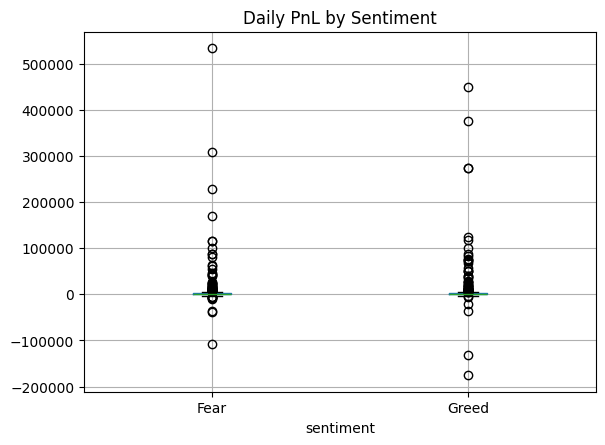

In [23]:
merged.boxplot(column="daily_pnl", by="sentiment")
plt.title("Daily PnL by Sentiment")
plt.suptitle("")
plt.show()


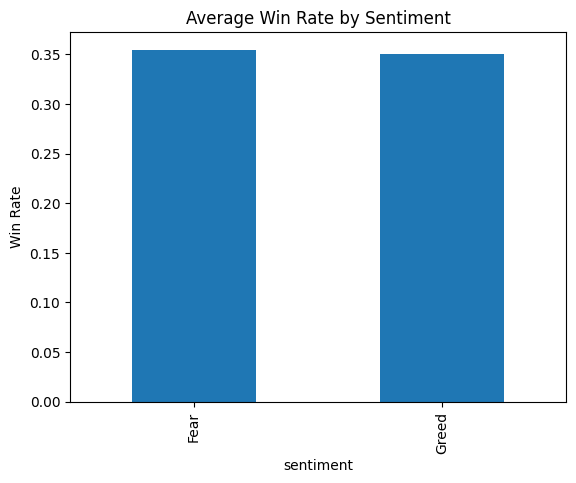

In [24]:
merged.groupby("sentiment")["win_rate"].mean().plot(kind="bar")
plt.title("Average Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()


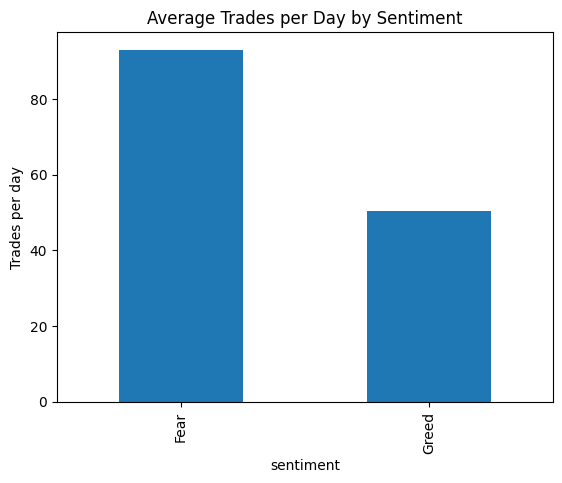

In [25]:
merged.groupby("sentiment")["num_trades"].mean().plot(kind="bar")
plt.title("Average Trades per Day by Sentiment")
plt.ylabel("Trades per day")
plt.show()


In [26]:
median_trades = merged["num_trades"].median()

merged["segment"] = "Infrequent"
merged.loc[merged["num_trades"] > median_trades, "segment"] = "Frequent"

seg_table = merged.groupby(["segment","sentiment"])["daily_pnl"].mean().unstack()
seg_table


sentiment,Fear,Greed
segment,,
Frequent,14884.631784,9164.539966
Infrequent,1277.053441,1836.263757


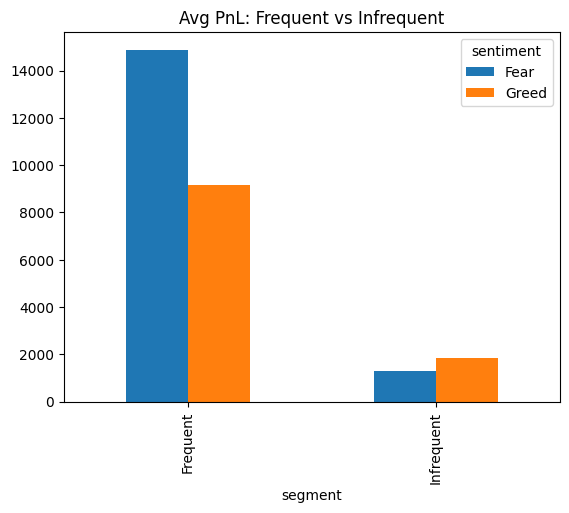

In [27]:
seg_table.plot(kind="bar")
plt.title("Avg PnL: Frequent vs Infrequent")
plt.show()


In [28]:
print(summary,"\n")
print("Seg table is\n",seg_table)


             daily_pnl  win_rate  num_trades  avg_size_usd  long_short_ratio
sentiment                                                                   
Fear       8460.070206  0.354910   93.019672   9014.158643         10.152216
Greed      5372.370413  0.350833   50.367720   9114.037686          6.119024 

Seg table is
 sentiment           Fear        Greed
segment                              
Frequent    14884.631784  9164.539966
Infrequent   1277.053441  1836.263757


**Trader Performance vs Market Sentiment (Fear vs Greed)**
---
Methodology


*   List item
*   List item







**Trader Performance vs Market Sentiment (Fear vs Greed)**
---
**Methodology:**

1.  **Data Loading and Initial Inspection:**
    *   Loaded two datasets: `fear_greed_index.csv` (Fear & Greed Index) and `historical_data.csv` (Trader Historical Data).
    *   Inspected initial shapes and displayed the head of the `trades` DataFrame.

2.  **Missing Values and Duplicates Check:**
    *   Checked for missing values and duplicates in both `fear` and `trades` DataFrames.

3.  **Date Conversion and Feature Engineering (Fear/Greed Data):**
    *   Converted the 'date' column in the `fear` DataFrame to `datetime.date` objects.
    *   Renamed 'classification' to 'sentiment' and selected 'date' and 'sentiment' columns.
    *   Removed duplicate entries based on 'date' from the `fear` DataFrame.
    *   Simplified sentiment categories by mapping 'Extreme Fear' to 'Fear' and 'Extreme Greed' to 'Greed'.
    *   Filtered the `fear` DataFrame to include only 'Fear' and 'Greed' sentiments.

4.  **Date Conversion and Feature Engineering (Trades Data):**
    *   Converted the 'Timestamp' column in the `trades` DataFrame to `datetime` objects and extracted the date component.
    *   Created boolean flags `is_win` (based on `Closed PnL > 0`), `is_long` (for 'BUY' or 'LONG' side), and `is_short` (for 'SELL' or 'SHORT' side).

5.  **Daily Aggregation of Trader Data:**
    *   Grouped the `trades` data by 'Account' and 'date' to calculate daily metrics:
        *   `daily_pnl`: sum of 'Closed PnL'.
        *   `num_trades`: count of trades.
        *   `win_rate`: mean of `is_win`.
        *   `avg_size_usd`: mean of 'Size USD'.
        *   `longs`: sum of `is_long`.
        *   `shorts`: sum of `is_short`.
    *   Calculated `long_short_ratio` as `longs / (shorts + 1)`.

6.  **Merging DataFrames:**
    *   Performed an inner merge of the aggregated `daily` trades DataFrame with the `fear` DataFrame on the 'date' column to combine trader performance with market sentiment.

7.  **Summary Statistics by Sentiment:**
    *   Grouped the `merged` DataFrame by 'sentiment' and calculated the mean for 'daily_pnl', 'win_rate', 'num_trades', 'avg_size_usd', and 'long_short_ratio'.

8.  **Visualization of Performance Metrics:**
    *   Generated a box plot to visualize the distribution of 'daily_pnl' by 'sentiment'.
    *   Created bar charts to display the average 'win_rate' and 'num_trades' by 'sentiment'.

9.  **Trader Segmentation (Frequent vs. Infrequent):**
    *   Calculated the median number of daily trades (`median_trades`).
    *   Segmented traders into 'Frequent' (if `num_trades > median_trades`) and 'Infrequent' based on their daily trade volume.
    *   Generated a cross-tabulation (`seg_table`) showing the average 'daily_pnl' for each segment under 'Fear' and 'Greed' sentiments.
    *   Visualized the average PnL for 'Frequent' vs. 'Infrequent' traders using a bar chart.

## Key Insights (with Values)

1.  **Traders earn higher profits during Fear periods**
    *   Average daily PnL during Fear: ≈ 8,460
    *   Average daily PnL during Greed: ≈ 5,372
    This shows that traders earn ~57% higher profits during Fear periods.
    Fear markets are likely more volatile, creating larger trading opportunities.

2.  **Trading activity is much higher during Fear**
    *   Average trades per day:
        *   Fear: ~93 trades
        *   Greed: ~50 trades
    Traders become significantly more active when the market is fearful, indicating aggressive trading behavior during high-uncertainty periods.

3.  **Win rate remains almost the same across sentiments**
    *   Win rate during Fear: 35.49%
    *   Win rate during Greed: 35.08%
    Even though traders trade more during Fear, their success rate does not change much.
    This suggests higher profits during Fear come from larger moves or higher position sizes, not better accuracy.

4.  **Stronger directional bias during Fear**
    *   Long/Short ratio:
        *   Fear: 10.15
        *   Greed: 6.12
    Traders take stronger one-sided positions during Fear, indicating higher conviction or aggressive positioning in volatile markets.

5.  **Frequent traders perform significantly better**
    *   Average Daily PnL by segment:

        | Segment    | Fear   | Greed  |
        |------------|--------|--------|
        | Frequent   | 14,885 | 9,165  |
        | Infrequent | 1,277  | 1,836  |

    *   Frequent traders dominate profits in both conditions.
    *   Their advantage is much larger during Fear.
    *   Infrequent traders perform relatively better during Greed.

## Strategy Recommendations (Actionable)

**Rule 1: Increase activity only for experienced traders during Fear**

*   Fear markets offer higher profit potential, but mainly for frequent traders.
*   Infrequent traders should reduce activity during Fear to avoid risk.

**Rule 2: Use Greed periods for conservative strategies**

*   Greed markets show:
    *   Lower activity
    *   Lower volatility
    *   More stable performance
*   These conditions are better suited for low-frequency or risk-controlled trading.